In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import keras
from keras_unet.models import custom_unet
from sklearn.model_selection import train_test_split

2023-02-06 17:54:01.187151: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/Nathan Arnett Calcification'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [4]:
images = np.load(images_file)
labels = np.load(labels_file)

In [5]:
images.ndim, labels.ndim

(3, 3)

In [6]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [7]:
p = np.random.permutation(len(images))

In [8]:
images = images[p]
labels = labels[p]

In [9]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [10]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [11]:
images.shape

(503, 512, 512, 1)

In [12]:
labels.shape

(503, 512, 512, 1)

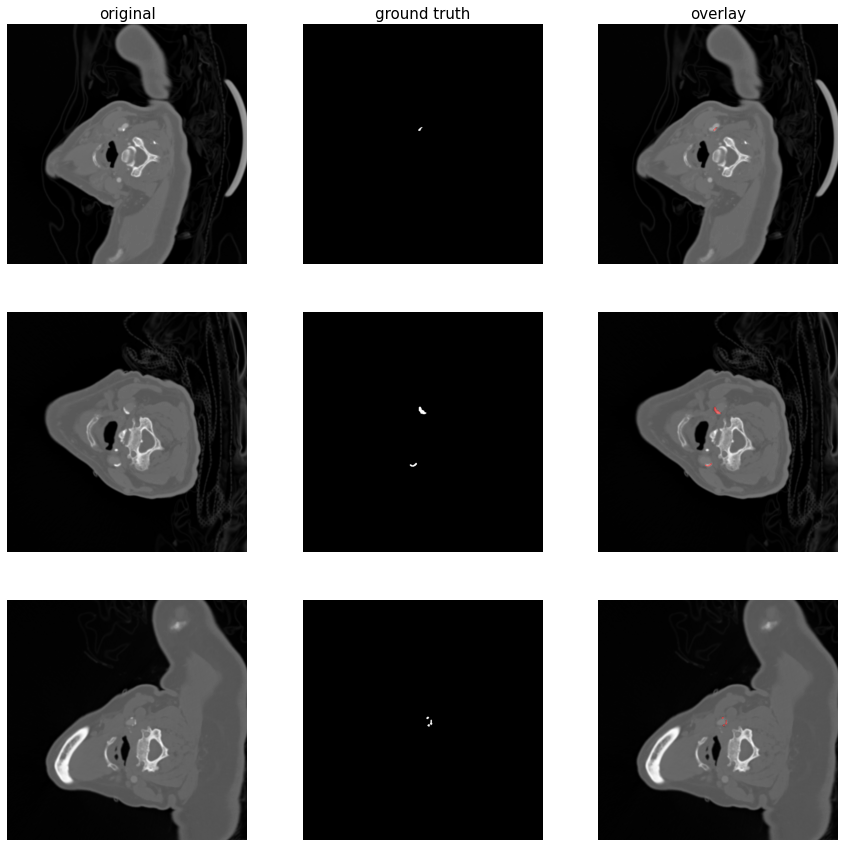

In [13]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=images, mask_imgs=labels, nm_img_to_plot=3, figsize=5)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=0)

In [15]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=64,
                               n_labels=1, depth=4, stack_num_down=4, stack_num_up=4,
                               patch_size=(4, 4), num_heads=[4, 8, 16, 16],
                               window_size=[4, 2, 2, 2], num_mlp=512, 
                               output_activation='Sigmoid', shift_window=True, name='swin_unet')

#Softmax

2023-02-06 17:54:27.869174: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-06 17:54:27.951935: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-06 17:54:27.951972: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-06 17:54:27.952009: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-06 17:54:27.952028: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-06 17:54:27.959854: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2023-02-06 17:54:27.980231: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 17:54:27.982925: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-06 17:54:27.988094: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2023-02-06 17:54:27.988424: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-06 17:54:28.726973: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecuto

In [16]:
model.summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
patch_extract (patch_extract)   (None, 16384, 16)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_embedding (patch_embeddin (None, 16384, 64)    1049664     patch_extract[0][0]              
__________________________________________________________________________________________________
swin_transformer_block (SwinTra (None, 16384, 64)    83460       patch_embedding[0][0]            
____________________________________________________________________________________

In [17]:
from tensorflow.keras import optimizers
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet_collection import losses

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr = 0.001),
              metrics=[iou, iou_thresholded])

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [19]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=16, 
                    epochs=200,
                    validation_data=(X_val, y_val))

2023-02-06 17:54:42.311827: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-06 17:54:42.333221: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200


2023-02-06 17:55:07.010681: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-06 17:55:08.228243: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-06 17:55:08.228586: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-06 17:55:08.365171: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-02-06 17:55:08.549304: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500
2023-02-06 17:55:09.338224: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-02-06 17:55:09.338243: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-02-06 17:55:09.33862

26/26 [==============================] - 51s 932ms/step - loss: 0.0662 - iou: 0.0012 - iou_thresholded: 0.0013 - val_loss: 0.0081 - val_iou: 0.0020 - val_iou_thresholded: 0.0020
Epoch 2/200
26/26 [==============================] - 19s 728ms/step - loss: 0.0074 - iou: 0.0011 - iou_thresholded: 0.0013 - val_loss: 0.0069 - val_iou: 0.0020 - val_iou_thresholded: 0.0020
Epoch 3/200
26/26 [==============================] - 19s 723ms/step - loss: 0.0057 - iou: 0.0011 - iou_thresholded: 0.0014 - val_loss: 0.0029 - val_iou: 0.0013 - val_iou_thresholded: 0.0020
Epoch 4/200
26/26 [==============================] - 19s 723ms/step - loss: 0.0033 - iou: 0.0017 - iou_thresholded: 0.0018 - val_loss: 0.0074 - val_iou: 0.0020 - val_iou_thresholded: 0.0020
Epoch 5/200
26/26 [==============================] - 19s 721ms/step - loss: 0.0054 - iou: 0.0011 - iou_thresholded: 0.0013 - val_loss: 0.0029 - val_iou: 0.0013 - val_iou_thresholded: 0.0020
Epoch 6/200
26/26 [==============================] - 19s 726ms

Epoch 43/200
26/26 [==============================] - 19s 723ms/step - loss: 2.7256e-04 - iou: 0.4698 - iou_thresholded: 0.5891 - val_loss: 4.7324e-04 - val_iou: 0.3515 - val_iou_thresholded: 0.3862
Epoch 44/200
26/26 [==============================] - 19s 728ms/step - loss: 2.8466e-04 - iou: 0.4521 - iou_thresholded: 0.5552 - val_loss: 4.2932e-04 - val_iou: 0.3806 - val_iou_thresholded: 0.4623
Epoch 45/200
26/26 [==============================] - 19s 726ms/step - loss: 2.7720e-04 - iou: 0.4717 - iou_thresholded: 0.5775 - val_loss: 4.3852e-04 - val_iou: 0.3701 - val_iou_thresholded: 0.4272
Epoch 46/200
26/26 [==============================] - 19s 722ms/step - loss: 2.5787e-04 - iou: 0.4915 - iou_thresholded: 0.6080 - val_loss: 4.3565e-04 - val_iou: 0.3817 - val_iou_thresholded: 0.4472
Epoch 47/200
26/26 [==============================] - 19s 732ms/step - loss: 2.4225e-04 - iou: 0.5001 - iou_thresholded: 0.6223 - val_loss: 4.1554e-04 - val_iou: 0.3908 - val_iou_thresholded: 0.4486
Epoch

26/26 [==============================] - 19s 717ms/step - loss: 2.1479e-05 - iou: 0.9267 - iou_thresholded: 0.9851 - val_loss: 6.3921e-04 - val_iou: 0.5160 - val_iou_thresholded: 0.5288
Epoch 126/200
26/26 [==============================] - 19s 732ms/step - loss: 2.0185e-05 - iou: 0.9261 - iou_thresholded: 0.9839 - val_loss: 6.4494e-04 - val_iou: 0.5145 - val_iou_thresholded: 0.5276
Epoch 127/200
26/26 [==============================] - 19s 723ms/step - loss: 2.6354e-05 - iou: 0.9181 - iou_thresholded: 0.9756 - val_loss: 6.6124e-04 - val_iou: 0.5085 - val_iou_thresholded: 0.5209
Epoch 128/200
26/26 [==============================] - 19s 729ms/step - loss: 3.2291e-05 - iou: 0.9082 - iou_thresholded: 0.9633 - val_loss: 7.0143e-04 - val_iou: 0.5005 - val_iou_thresholded: 0.5103
Epoch 129/200
26/26 [==============================] - 19s 726ms/step - loss: 4.1051e-05 - iou: 0.8869 - iou_thresholded: 0.9420 - val_loss: 6.6431e-04 - val_iou: 0.5008 - val_iou_thresholded: 0.5120
Epoch 130/200


26/26 [==============================] - 19s 729ms/step - loss: 2.3324e-05 - iou: 0.9428 - iou_thresholded: 0.9741 - val_loss: 8.7714e-04 - val_iou: 0.4944 - val_iou_thresholded: 0.5022
Epoch 167/200
26/26 [==============================] - 19s 727ms/step - loss: 5.4449e-05 - iou: 0.8942 - iou_thresholded: 0.9263 - val_loss: 0.0011 - val_iou: 0.4213 - val_iou_thresholded: 0.4391
Epoch 168/200
26/26 [==============================] - 19s 722ms/step - loss: 372.5117 - iou: 0.1671 - iou_thresholded: 0.1737 - val_loss: 17.4028 - val_iou: 2.1725e-04 - val_iou_thresholded: 2.1662e-04
Epoch 169/200
26/26 [==============================] - 19s 716ms/step - loss: 1.4196 - iou: 7.6839e-04 - iou_thresholded: 7.6967e-04 - val_loss: 0.0553 - val_iou: 0.0020 - val_iou_thresholded: 0.0020
Epoch 170/200
26/26 [==============================] - 19s 724ms/step - loss: 0.0550 - iou: 0.0018 - iou_thresholded: 0.0018 - val_loss: 0.0385 - val_iou: 0.0014 - val_iou_thresholded: 0.0015
Epoch 171/200
26/26 [==

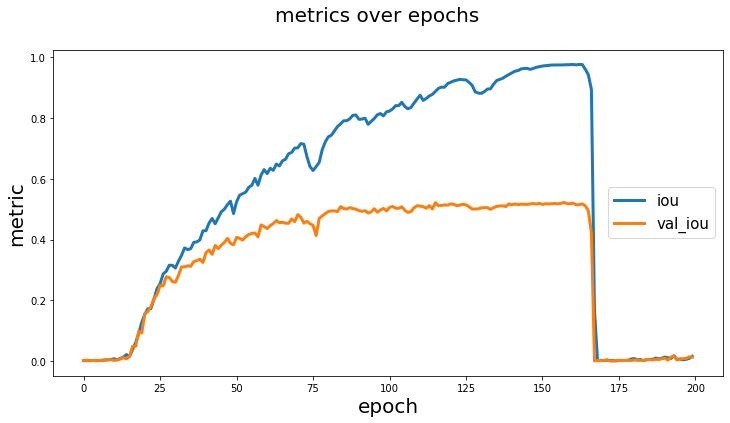

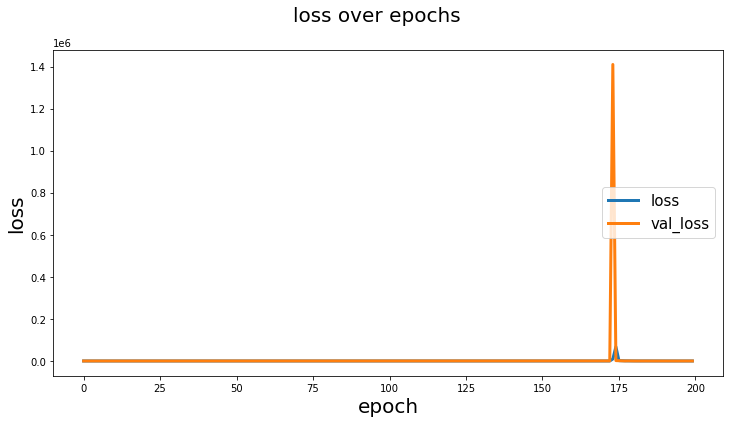

In [20]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [21]:
y_pred = model.predict(X_val)

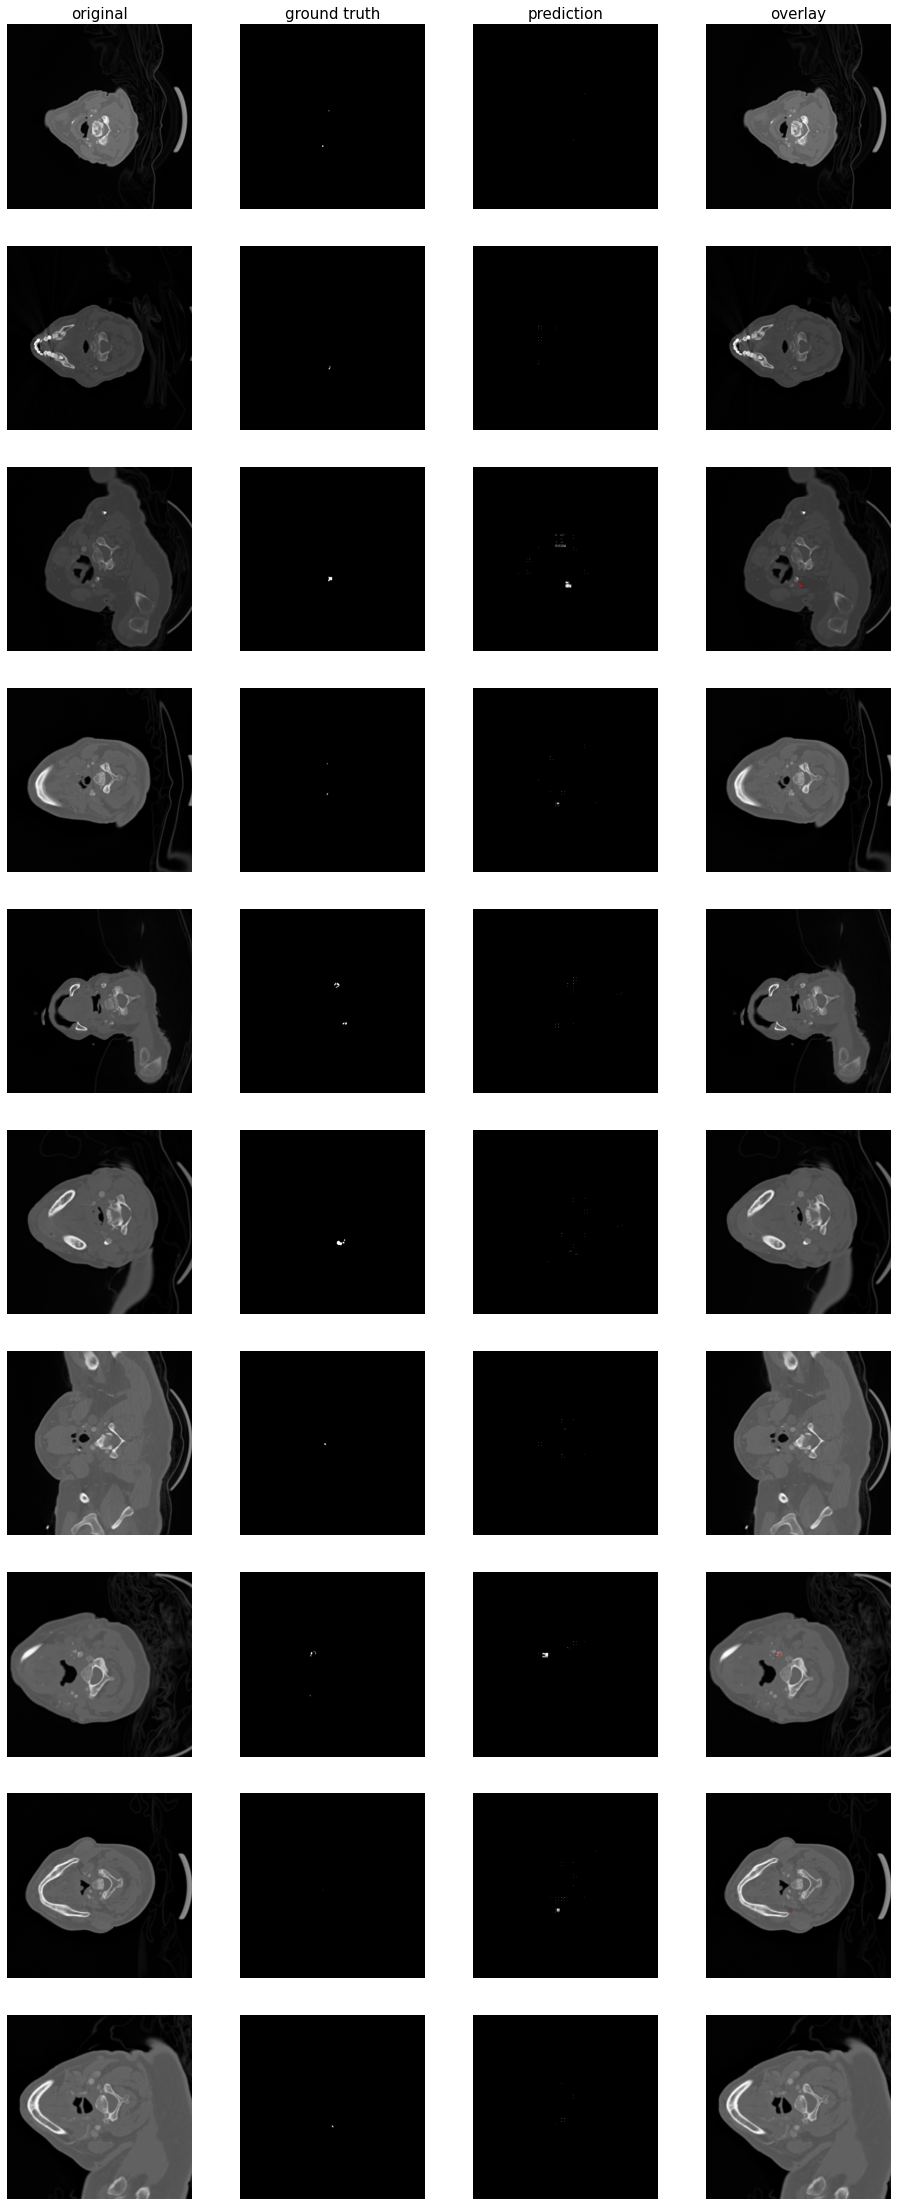

In [22]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [23]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

4/4 [==============================] - 2s 351ms/step - loss: 7.2845 - iou: 0.0114 - iou_thresholded: 0.0114
